### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [99]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [100]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [101]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [102]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [103]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

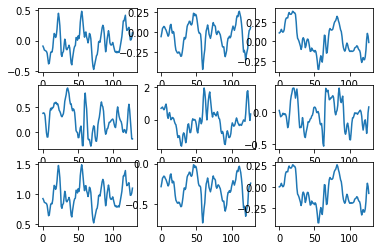

In [104]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [105]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [106]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [107]:
import sklearn
from sklearn import metrics
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with several layers of SimpleRNNs
* Model with several CNN layers
* Mixed model with several layers of CNNs, then its output model with 1+ layers of SimpleRNNs

Try with different number of units.

Report about your findings.

In [108]:
import tensorflow as tf

from keras.layers import Dense, SimpleRNN, InputLayer, Conv2D, Flatten, Dropout,Reshape
from keras.models import Model, Sequential
from keras.optimizers import RMSprop, Adam

### Single Layer SimpleRNN

In [109]:
### START YOUR CODE
n_hidden = 64
alpha = 0.001
clipnorm = 0.15
n_steps = X_train.shape[1]
n_input = X_train.shape[2]

model = Sequential()
model.add(SimpleRNN(units=n_hidden, return_sequences=False, activation='tanh',input_shape=(n_steps,n_input)))

model.add(Dense(N_CLASSES, activation='softmax'))

optimizer = RMSprop(alpha, clipnorm = clipnorm)

model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics = ['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 64)                4736      
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 390       
Total params: 5,126
Trainable params: 5,126
Non-trainable params: 0
_________________________________________________________________


In [91]:
### START YOUR CODE
batch_size = 256
n_epochs   = 50

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/50
29/29 [==============================] - 2s 51ms/step - loss: 1.4690 - accuracy: 0.3996 - val_loss: 1.2079 - val_accuracy: 0.4907
Epoch 2/50
29/29 [==============================] - 1s 41ms/step - loss: 1.1512 - accuracy: 0.5047 - val_loss: 1.0039 - val_accuracy: 0.5266
Epoch 3/50
29/29 [==============================] - 1s 42ms/step - loss: 1.0017 - accuracy: 0.5452 - val_loss: 0.9163 - val_accuracy: 0.5796
Epoch 4/50
29/29 [==============================] - 1s 44ms/step - loss: 0.9540 - accuracy: 0.6022 - val_loss: 0.8622 - val_accuracy: 0.5979
Epoch 5/50
29/29 [==============================] - 1s 42ms/step - loss: 0.8103 - accuracy: 0.6525 - val_loss: 0.7718 - val_accuracy: 0.6512
Epoch 6/50
29/29 [==============================] - 1s 43ms/step - loss: 0.7198 - accuracy: 0.6941 - val_loss: 0.8290 - val_accuracy: 0.6722
Epoch 7/50
29/29 [==============================] - 1s 42ms/step - loss: 0.6973 - accuracy: 0.7009 - val_loss: 0.7709 - val_accuracy: 0.6783
Epoch 8/50
29

Train accuracy (end): 0.9224700927734375
Train accuracy (max): 0.9314472079277039
Test accuracy (end) : 0.8842890858650208
Test accuracy (max) : 0.8920936584472656


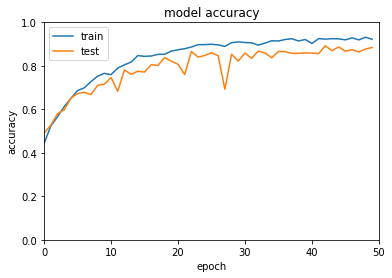

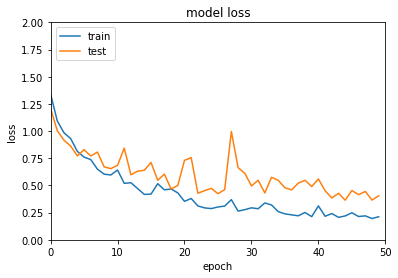

,walk,up,down,sit,stand,lay
walk,494,0,2,0,0,0
up,52,409,10,0,0,0
down,50,16,354,0,0,0
sit,0,4,0,341,146,0
stand,0,1,0,44,487,0
lay,0,1,15,0,0,521


In [92]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

batchsize 128, epochs 50, n_hidden 32, alpha 0.001, clipnorm 0.2:
- Irregular drops in accuracy
- Relatively smooth learning curve, thanks to norm clipping.
- 87% test accuracy, 92% train accuracy. This is quite a good result, not perfect tho.

batchsize 128, epochs 50, n_hidden 64, alpha 0.002, clipnorm 0.2:
- large drops in accuracy
- 83% test accuracy, 89% train accuracy

batchsize 128, epochs 50, n_hidden 64, alpha 0.001, clipnorm 0.3:
- 81% test accuracy, 93% train accuracy

batchsize 256, epochs 50, n_hidden 64, alpha 0.001, clipnorm 0.15:
- 89% test accuracy, 93% train accuracy


### Stacked Simple RNNs

In [110]:
### START YOUR CODE

n_hidden = 32
alpha = 0.001
clipnorm = 0.2
n_steps = X_train.shape[1]
n_input = X_train.shape[2]

model = Sequential()
model.add(SimpleRNN(units=n_hidden, return_sequences=True, activation='tanh',input_shape=(n_steps,n_input)))
model.add(SimpleRNN(units=n_hidden, return_sequences=True, activation='tanh'))
model.add(SimpleRNN(units=n_hidden, return_sequences=False, activation='tanh'))

model.add(Dense(N_CLASSES, activation='softmax'))

optimizer = RMSprop(alpha, clipnorm = clipnorm)

model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics = ['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_21 (SimpleRNN)    (None, 128, 32)           1344      
_________________________________________________________________
simple_rnn_22 (SimpleRNN)    (None, 128, 32)           2080      
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 198       
Total params: 5,702
Trainable params: 5,702
Non-trainable params: 0
_________________________________________________________________


In [94]:
### START YOUR CODE
batch_size = 128
n_epochs   = 50

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/50
58/58 [==============================] - 6s 73ms/step - loss: 1.3387 - accuracy: 0.4950 - val_loss: 0.9105 - val_accuracy: 0.6054
Epoch 2/50
58/58 [==============================] - 4s 65ms/step - loss: 0.7605 - accuracy: 0.6990 - val_loss: 0.7567 - val_accuracy: 0.6685
Epoch 3/50
58/58 [==============================] - 4s 68ms/step - loss: 0.6510 - accuracy: 0.7342 - val_loss: 0.6432 - val_accuracy: 0.7262
Epoch 4/50
58/58 [==============================] - 4s 70ms/step - loss: 0.5569 - accuracy: 0.7789 - val_loss: 0.6273 - val_accuracy: 0.7418
Epoch 5/50
58/58 [==============================] - 4s 70ms/step - loss: 0.5097 - accuracy: 0.8065 - val_loss: 0.6449 - val_accuracy: 0.7387
Epoch 6/50
58/58 [==============================] - 4s 69ms/step - loss: 0.4392 - accuracy: 0.8416 - val_loss: 0.5560 - val_accuracy: 0.8049
Epoch 7/50
58/58 [==============================] - 4s 71ms/step - loss: 0.4049 - accuracy: 0.8577 - val_loss: 0.5555 - val_accuracy: 0.8331
Epoch 8/50
58

Train accuracy (end): 0.9457290768623352
Train accuracy (max): 0.9457290768623352
Test accuracy (end) : 0.8829317688941956
Test accuracy (max) : 0.8832710981369019


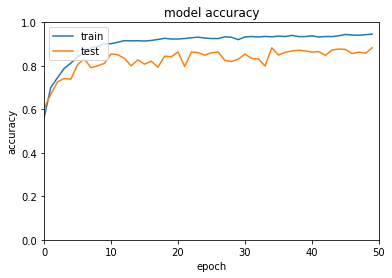

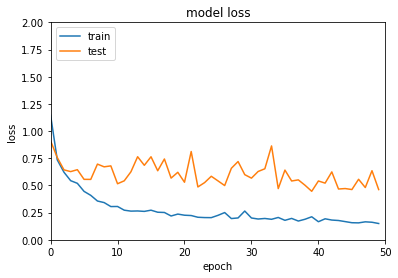

,walk,up,down,sit,stand,lay
walk,474,1,21,0,0,0
up,25,421,22,2,1,0
down,19,23,378,0,0,0
sit,0,13,1,334,143,0
stand,1,0,0,44,487,0
lay,0,27,2,0,0,508


In [95]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

2 layers: n_hidden 32, alpha 0.001, clipnorm = 0.2, batch_size 128, epochs 50:
- Large learning drops on test set
- Better acuracy than with 1 SimpleRNN layer (90% on test, 93% on train)

3 layers: n_hidden 32, alpha 0.001, clipnorm = 0.2, batch_size 128, epochs 50:
- Loss on test not following closely train loss.
- accuracy : 88% on test, 94% on train

### Several CNN Layers

In [111]:
### START YOUR CODE
n_steps = X_train.shape[1]
n_input = X_train.shape[2]
dropout_rate = .5
alpha = 0.001



model = Sequential()

model.add(InputLayer(input_shape=(n_steps, n_input,1)))
model.add(Conv2D(filters=16,kernel_size=(5,1),strides=(2,1),activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Conv2D(filters=32,kernel_size=(3,1),strides=(2,1),activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Conv2D(filters=64,kernel_size=(3,1),strides=(2,1),activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Conv2D(filters=64,kernel_size=(3,1),strides=(2,1),activation='relu'))
model.add(Flatten())
model.add(Dense(N_CLASSES,activation="softmax"))

optimizer = Adam(alpha)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
### END YOUR CODE

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 9, 16)         96        
_________________________________________________________________
dropout_12 (Dropout)         (None, 62, 9, 16)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 9, 32)         1568      
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 9, 32)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 9, 64)         6208      
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 9, 64)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 6, 9, 64)        

In [96]:
### START YOUR CODE
batch_size = 128
n_epochs   = 50

X_train = X_train.reshape((*X_train.shape,1))
X_test = X_test.reshape((*X_test.shape,1))

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/50


ValueError: in user code:

    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_29 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 128, 9, 1)


Train accuracy (end): 0.9542981386184692
Train accuracy (max): 0.9568824768066406
Test accuracy (end) : 0.9032914638519287
Test accuracy (max) : 0.9267051219940186


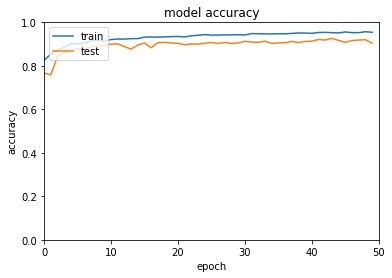

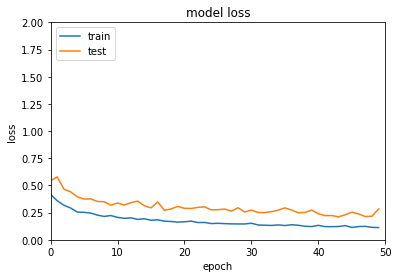

,walk,up,down,sit,stand,lay
walk,487,2,6,0,1,0
up,31,429,9,0,1,1
down,38,32,349,0,1,0
sit,0,3,0,374,113,1
stand,1,1,0,44,486,0
lay,0,0,0,0,0,537


In [62]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

- Way more parameters to train (40'000 vs ~3000)
- Stable learning curve, almost to flat, but still a good accuracy (90% on test, 95% on train). Actually the best accuracy for now.
- No accuracy drop while training, no overfitting

### Mixed CNN and RNN

In [114]:
### START YOUR CODE

model = Sequential()

model.add(InputLayer(input_shape=(n_steps, n_input,1)))
model.add(Conv2D(filters=16,kernel_size=(5,1),strides=(2,1),activation='relu'))
model.add(Conv2D(filters=32,kernel_size=(3,1),strides=(2,1),activation='relu'))
model.add(Reshape((30,9*32)))
model.add(SimpleRNN(units=n_hidden, return_sequences=True))
model.add(SimpleRNN(units=n_hidden, return_sequences=False))
model.add(Dense(N_CLASSES,activation='softmax'))

optimizer=Adam(alpha)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
### END YOUR CODE

model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 62, 9, 16)         96        
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 30, 9, 32)         1568      
_________________________________________________________________
reshape_5 (Reshape)          (None, 30, 288)           0         
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, 30, 32)            10272     
_________________________________________________________________
simple_rnn_26 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 198       
Total params: 14,214
Trainable params: 14,214
Non-trainable params: 0
_________________________________________________

In [115]:
### START YOUR CODE
batch_size = 128
n_epochs   = 50

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/50


ValueError: in user code:

    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/jean/Desktop/master/T-DeLearn/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_36 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 128, 9)


Train accuracy (end): 0.9609630107879639
Train accuracy (max): 0.9624592065811157
Test accuracy (end) : 0.9182218909263611
Test accuracy (max) : 0.9182218909263611


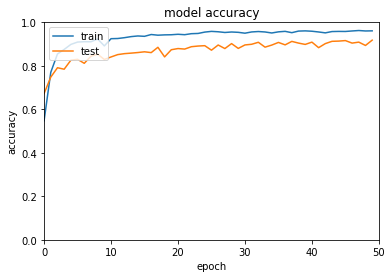

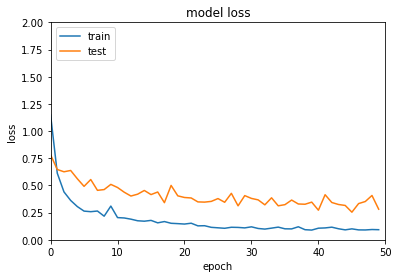

,walk,up,down,sit,stand,lay
walk,492,2,2,0,0,0
up,19,435,17,0,0,0
down,4,21,395,0,0,0
sit,0,2,1,428,60,0
stand,0,0,0,86,446,0
lay,0,27,0,0,0,510


In [68]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

- Best overall accuracy (92% on test, 97% on train)